In [1]:
import numpy as np
import qutip
import dimer
import matplotlib.pyplot as plt

In [2]:
# Statistics
ntraj = 10**2

# Physical parameters.
lambdas = [[.25, .25],
           [.25, 1.75],
           [1.25, .25]]

omega_S = 1
dt = 0.01
T = 20
t_eval = np.array([0, T])

# solver = "trsolve"
solver = "mcsolve"
# solver = "gutzwiller"

store_states = False
compute_eentropy = False
compute_fidelity = False

no_click = False

psi0 = qutip.tensor(qutip.basis(2, 1), qutip.basis(2, 1))

In [3]:
sim_list = dimer.get_sim_list(lambdas,
                              omega_S,
                              psi0,
                              t_eval,
                              ntraj,
                              dt,
                              solver,
                              no_click)

In [4]:
data = []

for sim in sim_list:
    f = open(f"data/{str(sim)}.npz", "rb")
    data.append(np.load(f))
    # f.close()

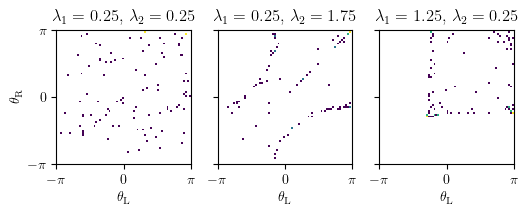

In [5]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 72
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = data[i]['bloch_coords'][:-1,0,1]
    tr = data[i]['bloch_coords'][:-1,1,1]
    
    axs[i].hist2d(tl, tr,
                  density=True,
                  range=binning_range,
                  bins=bins,
                  norm="log")
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_yticks(ticks)
    axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L}$", ylabel=r"$\theta_\mathrm{R}$")
    axs[i].set(aspect='equal')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# plt.savefig("plots/dimer-full-p-infty-mc.pdf")